In [1]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation import DeepLabV3_ResNet101_Weights
from torchvision import models
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import segmentation_models_pytorch as smp
from utils import SegDataset, collate_fn
import torch

In [2]:
model = models.segmentation.deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT,
                                                progress=True)

In [3]:
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [4]:
model.classifier = DeepLabHead(2048, 1)

In [5]:
from PIL import Image
from torchvision import transforms
input_image = Image.open('data/train/0.png')
input_image = input_image.convert("RGB")
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
preprocess = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])
inv_normalize = transforms.Normalize(
    mean=[-m/s for m,s in zip(mean, std)],
    std=[1/s for s in std]
)

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

In [6]:
model.eval()
with torch.no_grad():
    output = model(input_batch)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [7]:
dataset = SegDataset('', transform=preprocess)

In [8]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
def plot_sample(sample, index=-1):
    axis = plt.gca()
    axis.imshow(to_pil_image(inv_normalize(sample['pixel_values'])))
    if len(sample['labels']):
        axis.contourf(sample['labels'], levels=1, colors='none', hatches=['', 'oo'])
    axis.set_title('Sample #{}'.format(index))
    axis.axis('off')
    if axis is None:
        plt.show()  # Otherwise we'll assume you're composing your own plot

In [9]:
def plot_evaluation(sample, predict, index=-1):
    # Create the plot
    fig, axis = plt.subplots()

    # Display the image
    axis.imshow(to_pil_image(inv_normalize(sample['pixel_values'])))

    # Ground truth labels
    labels = sample['labels']
    
    # Predicted labels
    if len(labels) > 0 and len(predict) > 0:
        # Compute overlap: both labels and predictions are 1
        overlap = (labels == 1) & (predict == 1)
        # Labels are 1 but no overlap with prediction
        no_overlap = (labels == 1) & (predict == 0)

        axis.contourf(no_overlap, levels=[0.5, 1], colors='none', hatches=['xx'], alpha=0.5)  # Hatched brown
        axis.contourf(overlap, levels=[0.5, 1], colors='none', hatches=['oo'], alpha=0.5)      # Hatched black

    # Set plot title and turn off axis
    axis.set_title(f'Sample #{index}')
    axis.axis('off')

    # Show the plot
    plt.show()

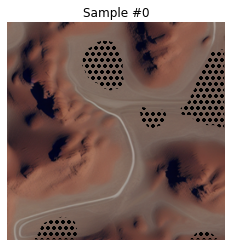

In [10]:
plot_sample(dataset[42], index=0)

In [11]:
model.eval()
with torch.no_grad():
    output = model(dataset[0]['pixel_values'].unsqueeze(0))

In [12]:
threshold = 0.5  # This is the threshold value; adjust it based on your needs

# Apply threshold to binarize the tensor
output = torch.tensor((output['out'].squeeze(0, 1) > threshold), dtype=torch.long)

/tmp/ipykernel_81504/1237063656.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = torch.tensor((output['out'].squeeze(0, 1) > threshold), dtype=torch.long)


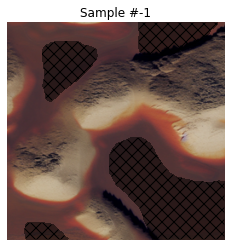

In [13]:
plot_evaluation(dataset[5780], output)

In [14]:
from torchmetrics.classification import BinaryJaccardIndex
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateFinder
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchvision.utils import make_grid
import wandb

class ModelModule(pl.LightningModule):
    def __init__(self, model, lr, criterion, batch_size, optim_name):
        super().__init__()
        self.model = model

        self.train_metric = BinaryJaccardIndex(threshold=0.5)
        self.val_metric = BinaryJaccardIndex(threshold=0.5)

        self.loss_fn = criterion
        self.lr = lr
        self.batch_size = batch_size
        self.optim_name = optim_name

        self.val_outputs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch['pixel_values'], batch['labels']
        logits = self.forward(x)['out']
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, batch_size=self.batch_size)
        probs = torch.nn.functional.sigmoid(logits.squeeze(1))
        self.train_metric(probs, y)
        self.log('train_metric', self.train_metric, on_epoch=True, prog_bar=True, on_step=False, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, paths = batch['pixel_values'], batch['labels'], batch['paths']
        logits = self.forward(x)['out']
        loss = self.loss_fn(logits, y)
        self.log("val_loss", loss, on_epoch=True, on_step=False, prog_bar=True, batch_size=self.batch_size)
        probs = torch.nn.functional.sigmoid(logits.squeeze(1))
        self.val_metric(probs, y)
        self.log('val_metric', self.val_metric, on_epoch=True, prog_bar=True, on_step=False, batch_size=self.batch_size)
        sampled_indices = torch.randperm(x.size(0))[:2]  # Example: select 2 random samples from the batch
        for idx in sampled_indices:
            self.val_outputs.append({
                'pixel_values': x[idx].cpu(),
                'labels': y[idx].cpu(),
                'probs': probs[idx].cpu(),
                'path': paths[idx]
            })
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x = batch['pixel_values']
        logits = self.forward(x)['out']
        probs = torch.nn.functional.sigmoid(logits.squeeze(1))
        return probs

    def on_validation_epoch_end(self):
        self.visualize_epoch_samples()
        self.val_outputs.clear()  # Clear the list after visualizing to avoid memory leaks

    def visualize_epoch_samples(self):
        samples = self.val_outputs[:10]

        for sample in self.val_outputs:
            img = inv_normalize(sample['pixel_values'])  # [3, 256, 256]
            labels = sample['labels'].unsqueeze(0).repeat(3, 1, 1)  # Expanding [1, 256, 256] to [3, 256, 256]
            preds = (sample['probs'] > 0.5).float()
            preds = preds.unsqueeze(0).repeat(3, 1, 1)  # Expanding [1, 256, 256] to [3, 256, 256]
    
            # Concatenate images horizontally
            tri_panel_image = torch.cat([
                img,  # Original image
                labels,  # Ground truth mask with repeated channels
                preds  # Predicted mask with repeated channels
            ], dim=2)  # Concatenate along width for channel-first format
    
            tri_panel_img_pil = to_pil_image(tri_panel_image)
    
            # Log the tri-panel image to wandb with a caption including the path and current epoch
            self.logger.experiment.log({
                "comparison": [wandb.Image(tri_panel_img_pil, caption=f"Epoch {self.current_epoch} - {sample['path']}")]
            })

    def configure_optimizers(self):
        if self.optim_name == 'Adam':
            opt = torch.optim.Adam(self.parameters(), lr=self.lr)
        else:
            opt = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=0.9, nesterov=True)
        reduce_lr_on_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt,
            mode='min',
            factor=0.1,
            patience=1,
            min_lr=1e-7,
            verbose=True
        )

        return {
            "optimizer": opt,
            "lr_scheduler" : {
                "scheduler" : reduce_lr_on_plateau,
                "monitor" : "val_loss",
            }
        }

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(


In [15]:
criterion = smp.losses.FocalLoss(mode='binary')
# criterion = smp.losses.JaccardLoss(mode='binary', log_loss=True)
# criterion = smp.losses.DiceLoss(mode='binary', log_loss=True)
lr = 5e-3
batch_size = 64
optim_name = 'SGD'

In [16]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
preprocess = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])
inv_normalize = transforms.Normalize(
    mean=[-m/s for m,s in zip(mean, std)],
    std=[1/s for s in std]
)

full_dataset = SegDataset(root_dir='', split='train', transform=preprocess)

# Splitting the dataset into train and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [17]:
# train_dataset = torch.utils.data.Subset(train_dataset, list(range(10)))
# val_dataset = torch.utils.data.Subset(val_dataset, list(range(10)))

In [18]:
train_batch_gen = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_batch_gen = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [19]:
checkpoint_callback = ModelCheckpoint(monitor='val_metric', mode='max', dirpath="models/DeepLabV3/", filename="DeepLabV3-{val_metric:.3f}")
early_stopping = EarlyStopping(monitor="val_metric", mode="max", patience=3)

In [20]:
from pytorch_lightning import loggers

# Set up a TensorBoard logger
wandb_logger = loggers.WandbLogger(log_model="all")

In [21]:
trainer = pl.Trainer(max_epochs=100, accelerator="gpu", devices=-1, callbacks=[checkpoint_callback, early_stopping], log_every_n_steps=50, logger=wandb_logger)

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
model_module = ModelModule(model, lr, criterion, batch_size, optim_name)

In [23]:
trainer.fit(model_module, train_dataloaders=train_batch_gen, val_dataloaders=val_batch_gen)

You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: maksimov-dmitry-m. Use `wandb login --relogin` to force relogin


/home/ubuntu/.local/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/ubuntu/task3/models/DeepLabV3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type               | Params
----------------------------------------------------
0 | model        | DeepLabV3          | 61.0 M
1 | train_metric | BinaryJaccardIndex | 0     
2 | val_metric   | BinaryJaccardIndex | 0     
3 | loss_fn      | FocalLoss          | 0     
----------------------------------------------------
61.0 M    Trainable params
0         Non-trainable params
61.0 M    Total params
243.964   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]